# Hyperbolic Tangent Look-Up-Table generator for bipolar representation [-1,1]
Input uses $s[4][3]$ precision giving a range of $[-16,15.875]$ at steps of $0.125$

Outpus uses $s[0][31]$ precision giving a range of $[-1,1]$

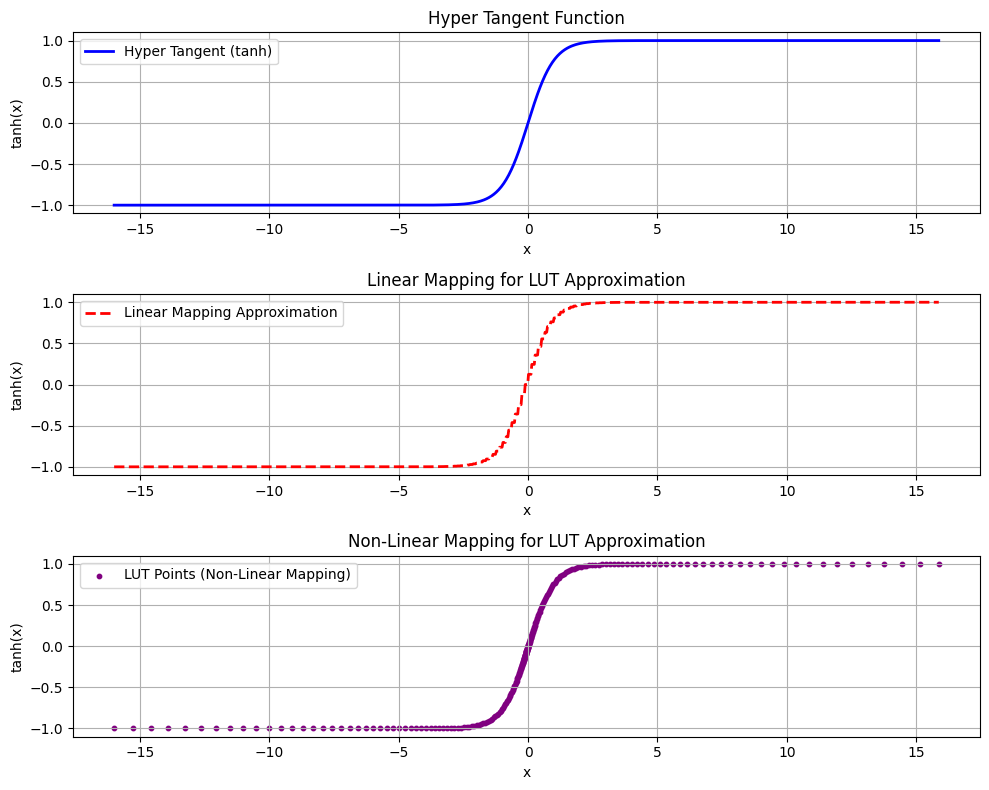

Binary Output for Linear Mapping:
8'sb10000000 : Tanh_LUT_out = 32'sb10000000000000000000000000000001;
8'sb10000001 : Tanh_LUT_out = 32'sb10000000000000000000000000000001;
8'sb10000010 : Tanh_LUT_out = 32'sb10000000000000000000000000000001;
8'sb10000011 : Tanh_LUT_out = 32'sb10000000000000000000000000000001;
8'sb10000100 : Tanh_LUT_out = 32'sb10000000000000000000000000000001;
8'sb10000101 : Tanh_LUT_out = 32'sb10000000000000000000000000000001;
8'sb10000110 : Tanh_LUT_out = 32'sb10000000000000000000000000000001;
8'sb10000111 : Tanh_LUT_out = 32'sb10000000000000000000000000000001;
8'sb10001000 : Tanh_LUT_out = 32'sb10000000000000000000000000000001;
8'sb10001001 : Tanh_LUT_out = 32'sb10000000000000000000000000000001;
8'sb10001010 : Tanh_LUT_out = 32'sb10000000000000000000000000000001;
8'sb10001011 : Tanh_LUT_out = 32'sb10000000000000000000000000000001;
8'sb10001100 : Tanh_LUT_out = 32'sb10000000000000000000000000000001;
8'sb10001101 : Tanh_LUT_out = 32'sb10000000000000000000000000000001;


In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Define the hyper tangent (tanh) function
def hyper_tangent(x):
    return np.tanh(x)

# Linear mapping for LUT points
def linear_mapping(n_points, x_min=-8, x_max=8):
    return np.linspace(x_min, x_max, n_points)

# Non-linear mapping for LUT points (e.g., hyperbolic sine for denser points near 0)
def non_linear_mapping(n_points, x_min=-8, x_max=8):
    lin_space = np.linspace(-2, 2, n_points)  # Uniform distribution in a smaller range
    x_values = np.sign(lin_space) * np.sinh(np.abs(lin_space) * 3)  # Exponential growth near 0
    # Normalize to the target x_min, x_max range
    x_values = (x_values - x_values.min()) / (x_values.max() - x_values.min()) * (x_max - x_min) + x_min
    return x_values

# Define a function to approximate hyper tangent using the LUT
def hyper_tangent_lut_approximation(x, lut, x_lut):
    # Find the closest x_lut index for the input x
    index = np.searchsorted(x_lut, x)  # Get the closest index in sorted x_lut
    if index <= 0:
        return lut[0]
    elif index >= len(lut):
        return lut[-1]
    else:
        return lut[index]

# Parameters
lut_size = 256  # Number of LUT entries
x_min, x_max = -16, 15.875

# Generate x-values for linear and non-linear mappings
x_lut_linear = linear_mapping(lut_size, x_min, x_max)
x_lut_non_linear = non_linear_mapping(lut_size, x_min, x_max)

# Generate LUT values (hyper tangent output) for both mappings
lut_linear = hyper_tangent(x_lut_linear)
lut_non_linear = hyper_tangent(x_lut_non_linear)

# Generate x values for comparison
x_values = np.linspace(x_min, x_max, 1000)

# Compute y values for both tanh and LUT approximations
y_tanh = hyper_tangent(x_values)
y_lut_linear = [hyper_tangent_lut_approximation(x, lut_linear, x_lut_linear) for x in x_values]
y_lut_non_linear = [hyper_tangent_lut_approximation(x, lut_non_linear, x_lut_non_linear) for x in x_values]


# Plotting the results
plt.figure(figsize=(10, 8))

# Subplot 1: Hyper Tangent Function
plt.subplot(3, 1, 1)
plt.plot(x_values, y_tanh, label='Hyper Tangent (tanh)', color='blue', linewidth=2)
plt.title('Hyper Tangent Function')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.grid(True)
plt.legend()

# Subplot 2: Linear Mapping Approximation
plt.subplot(3, 1, 2)
plt.plot(x_values, y_lut_linear, label='Linear Mapping Approximation', color='red', linestyle='dashed', linewidth=2)
plt.title('Linear Mapping for LUT Approximation')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.grid(True)
plt.legend()

# Subplot 3: Non-Linear Mapping Approximation
plt.subplot(3, 1, 3)
plt.scatter(x_lut_non_linear, lut_non_linear, label='LUT Points (Non-Linear Mapping)', color='purple', s=10)
plt.title('Non-Linear Mapping for LUT Approximation')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.grid(True)
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

def convert_lut_to_binary(lut, prefix="Tanh_LUT_out", index_width=8, value_width=32):
    """
    Convert LUT values to Verilog signed fixed-point format (s[0][31]).

    Parameters:
        lut (array-like): Lookup table values, normalized to the range [-1, 1].
        prefix (str): Prefix for the output signal name.
        index_width (int): Bit width for the LUT index (signed representation).
        value_width (int): Bit width for the LUT values (must be 32 for s[0][31]).

    Returns:
        list of str: Formatted binary representation for each LUT entry.
    """
    binary_lines = []
    scale_factor = 2**(value_width - 1) - 1  # Correct Q1.31 scaling (2^31 - 1)
    min_index = -16
    max_index = int(15.875 * 2**3) / 2**3  # Ensure correct fixed-point rounding

    lut_indices = np.arange(min_index, max_index + 2**-3, step=2**-3)

    expected_entries = round((max_index - min_index) * 2**3) + 1
    num_entries = len(lut)

    if num_entries != expected_entries:
        raise ValueError(f"LUT size {num_entries} does not match expected {expected_entries} for {index_width}-bit signed indices.")

    for i, value in zip(lut_indices, lut):
        # Scale to s[0][31] format
        scaled_value = int(round(value * scale_factor))

        # Clip values to ensure they fit within 32-bit signed range
        scaled_value = max(min(scaled_value, 2**31 - 1), -2**31)

        # Convert to signed 32-bit binary representation
        bin_value = f"{scaled_value & ((1 << value_width) - 1):032b}"

        # Convert index to signed fixed-point representation
        int_index = int(i * 2**3)
        if int_index < 0:
            bin_index = f"{(int_index + (1 << index_width)) & ((1 << index_width) - 1):0{index_width}b}"
        else:
            bin_index = f"{int_index:0{index_width}b}"

        # Format Verilog assignment
        binary_line = f"{index_width}'sb{bin_index} : {prefix} = {value_width}'sb{bin_value};"
        binary_lines.append(binary_line)
    
    return binary_lines
# Generate binary output for the linear LUT
binary_output_linear = convert_lut_to_binary(lut_linear, prefix="Tanh_LUT_out")

# Print the binary output for the linear LUT
print("Binary Output for Linear Mapping:")
for line in binary_output_linear:
    print(line)

# Generate binary output for the non-linear LUT
binary_output_non_linear = convert_lut_to_binary(lut_non_linear, prefix="Tanh_LUT_out")

# Print the binary output for the non-linear LUT
print("\nBinary Output for Non-Linear Mapping:")
for line in binary_output_non_linear:
    print(line)

# Hyperbolic Tangent Look-Up-Table generator for binary representation [0,1]
Input uses $s[4][3]$ precision giving a range of $[-16,15.875]$ at steps of $0.125$

Outpus uses $us[0][32]$ precision giving a range of $[0,0.9999999997]\approx[0,1]$

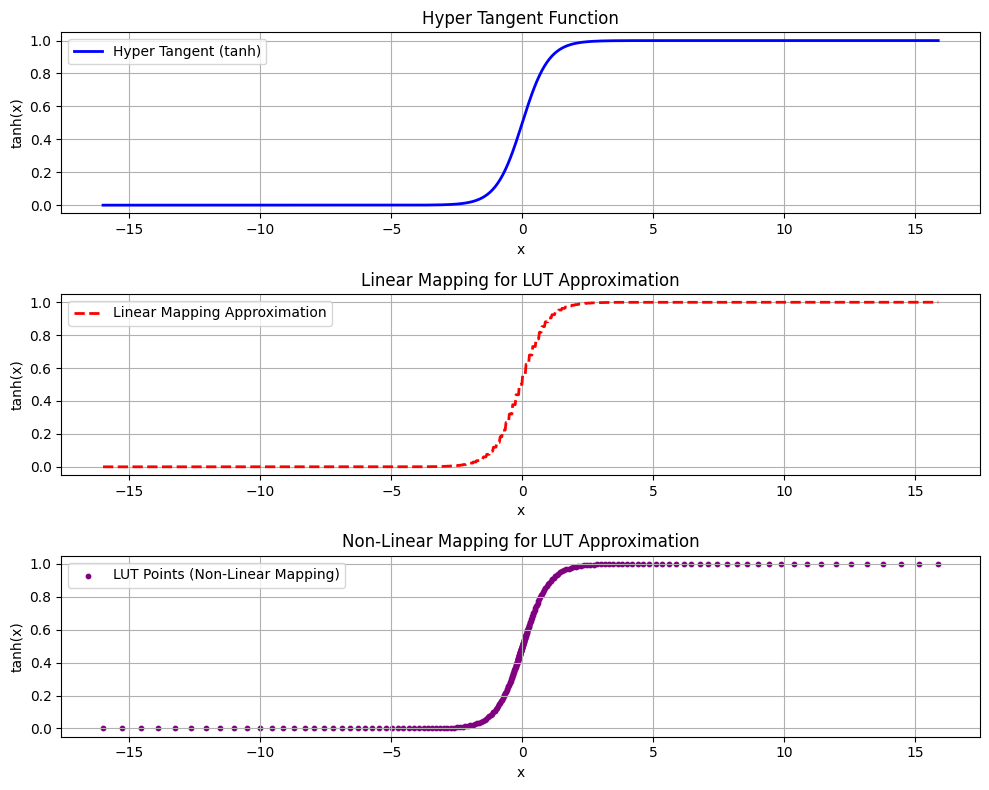

Binary Output for Linear Mapping:
8'b10000000 : Tanh_LUT_out = 32'b00000000000000000000000000000000;
8'b10000001 : Tanh_LUT_out = 32'b00000000000000000000000000000000;
8'b10000010 : Tanh_LUT_out = 32'b00000000000000000000000000000000;
8'b10000011 : Tanh_LUT_out = 32'b00000000000000000000000000000000;
8'b10000100 : Tanh_LUT_out = 32'b00000000000000000000000000000000;
8'b10000101 : Tanh_LUT_out = 32'b00000000000000000000000000000000;
8'b10000110 : Tanh_LUT_out = 32'b00000000000000000000000000000000;
8'b10000111 : Tanh_LUT_out = 32'b00000000000000000000000000000000;
8'b10001000 : Tanh_LUT_out = 32'b00000000000000000000000000000000;
8'b10001001 : Tanh_LUT_out = 32'b00000000000000000000000000000000;
8'b10001010 : Tanh_LUT_out = 32'b00000000000000000000000000000000;
8'b10001011 : Tanh_LUT_out = 32'b00000000000000000000000000000000;
8'b10001100 : Tanh_LUT_out = 32'b00000000000000000000000000000000;
8'b10001101 : Tanh_LUT_out = 32'b00000000000000000000000000000000;
8'b10001110 : Tanh_LUT_out =

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Define the hyper tangent (tanh) function
def hyper_tangent(x):
    return (np.tanh(x)+1)/2

# Linear mapping for LUT points
def linear_mapping(n_points, x_min=-8, x_max=8):
    return np.linspace(x_min, x_max, n_points)

# Non-linear mapping for LUT points (e.g., hyperbolic sine for denser points near 0)
def non_linear_mapping(n_points, x_min=-8, x_max=8):
    lin_space = np.linspace(-2, 2, n_points)  # Uniform distribution in a smaller range
    x_values = np.sign(lin_space) * np.sinh(np.abs(lin_space) * 3)  # Exponential growth near 0
    # Normalize to the target x_min, x_max range
    x_values = (x_values - x_values.min()) / (x_values.max() - x_values.min()) * (x_max - x_min) + x_min
    return x_values

# Define a function to approximate hyper tangent using the LUT
def hyper_tangent_lut_approximation(x, lut, x_lut):
    # Find the closest x_lut index for the input x
    index = np.searchsorted(x_lut, x)  # Get the closest index in sorted x_lut
    if index <= 0:
        return lut[0]
    elif index >= len(lut):
        return lut[-1]
    else:
        return lut[index]

# Parameters
lut_size = 256  # Number of LUT entries
x_min, x_max = -16, 15.875

# Generate x-values for linear and non-linear mappings
x_lut_linear = linear_mapping(lut_size, x_min, x_max)
x_lut_non_linear = non_linear_mapping(lut_size, x_min, x_max)

# Generate LUT values (hyper tangent output) for both mappings
lut_linear = hyper_tangent(x_lut_linear)
lut_non_linear = hyper_tangent(x_lut_non_linear)

# Generate x values for comparison
x_values = np.linspace(x_min, x_max, 1000)

# Compute y values for both tanh and LUT approximations
y_tanh = hyper_tangent(x_values)
y_lut_linear = [hyper_tangent_lut_approximation(x, lut_linear, x_lut_linear) for x in x_values]
y_lut_non_linear = [hyper_tangent_lut_approximation(x, lut_non_linear, x_lut_non_linear) for x in x_values]


# Plotting the results
plt.figure(figsize=(10, 8))

# Subplot 1: Hyper Tangent Function
plt.subplot(3, 1, 1)
plt.plot(x_values, y_tanh, label='Hyper Tangent (tanh)', color='blue', linewidth=2)
plt.title('Hyper Tangent Function')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.grid(True)
plt.legend()

# Subplot 2: Linear Mapping Approximation
plt.subplot(3, 1, 2)
plt.plot(x_values, y_lut_linear, label='Linear Mapping Approximation', color='red', linestyle='dashed', linewidth=2)
plt.title('Linear Mapping for LUT Approximation')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.grid(True)
plt.legend()

# Subplot 3: Non-Linear Mapping Approximation
plt.subplot(3, 1, 3)
plt.scatter(x_lut_non_linear, lut_non_linear, label='LUT Points (Non-Linear Mapping)', color='purple', s=10)
plt.title('Non-Linear Mapping for LUT Approximation')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.grid(True)
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

import numpy as np

import numpy as np

import numpy as np

def convert_lut_to_binary(lut, prefix="Tanh_LUT_out", index_width=8, value_width=32):
    """
    Convert LUT values to unsigned 32-bit fixed-point format (u[0][32]).

    Parameters:
        lut (array-like): Lookup table values, already normalized to [0, 1].
        prefix (str): Prefix for the output signal name.
        index_width (int): Bit width for the LUT index.
        value_width (int): Bit width for the LUT values (must be 32 for u[0][32]).

    Returns:
        list of str: Formatted binary representation for each LUT entry.
    """
    binary_lines = []
    scale_factor = (2**value_width) - 1  # Ensure correct unsigned range

    min_index = -16
    max_index = 15.875

    num_entries = len(lut)

    # Ensure proper index range
    lut_indices = np.linspace(min_index, max_index, num_entries, endpoint=True)

    for i, value in zip(lut_indices, lut):
        # LUT values are already in [0,1], no need for additional normalization
        normalized_value = value

        # Scale to unsigned 32-bit fixed-point format
        scaled_value = int(round(normalized_value * scale_factor))

        # Clamp to ensure 32-bit range
        scaled_value = max(0, min(scaled_value, (2**value_width) - 1))

        # Convert to 32-bit unsigned binary
        bin_value = f"{scaled_value:032b}"

        # Correct LUT indexing
        int_index = int(round(i * 2**3))
        bin_index = f"{int_index & ((1 << index_width) - 1):0{index_width}b}"

        # Format Verilog assignment
        binary_line = f"{index_width}'b{bin_index} : {prefix} = {value_width}'b{bin_value};"
        binary_lines.append(binary_line)
    
    return binary_lines

# Generate binary output for the linear LUT
binary_output_linear = convert_lut_to_binary(lut_linear, prefix="Tanh_LUT_out")

# Print the binary output for the linear LUT
print("Binary Output for Linear Mapping:")
for line in binary_output_linear:
    print(line)

# Print the binary output for the non-linear LUT
print("\nBinary Output for Non-Linear Mapping:")
for line in binary_output_non_linear:
    print(line)